# Rozpoznawanie komórek krwi na zdjęciach przy pomocy AI

## Cel projektu
Celem projektu jest stworzenie modelu opartego na sztucznej inteligencji, który będzie potrafił rozpoznawać i klasyfikować różne typy komórek krwi na podstawie obrazów mikroskopowych. Model ma znaleźć zastosowanie w medycynie, pomagając w diagnozowaniu chorób krwi poprzez automatyczną klasyfikację komórek.

## Tło i motywacja
Analiza komórek krwi jest kluczowa w diagnostyce wielu chorób, takich jak białaczka czy anemia. Obecnie diagnoza opiera się na ręcznej klasyfikacji komórek przez specjalistów, co może być czasochłonne i podatne na błędy ludzkie. Wykorzystanie głębokiego uczenia do automatyzacji tego procesu może znacząco zwiększyć dokładność diagnoz i usprawnić pracę lekarzy.

## Opis rozwiązania
Projekt polega na stworzeniu i wytrenowaniu modelu CNN (Convolutional Neural Network) do klasyfikacji obrazów komórek krwi. Wykorzystane zostaną dwa modele o różnej złożoności, aby porównać ich skuteczność i czas trenowania.

## Technologie i narzędzia
- **Język programowania**: Python
- **Biblioteki**: TensorFlow
- **Środowisko**: Jupyter Notebook

In [2]:
# Importowanie modułów

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2025-02-25 14:36:19.808567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 14:36:19.845353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 14:36:20.584531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


## Wczytywanie zbioru danych

Zbiór danych: [Blood Cell Images](https://www.kaggle.com/datasets/paultimothymooney/blood-cells)

Zbiór danych zawiera obrazy mikroskopowe różnych typów komórek krwi, podzielone na klasy. Każdy obraz jest w formacie RGB i ma rozdzielczość (320x240). Dane są podzielone na zbiór treningowy i testowy, co pozwala ocenić skuteczność modelu.

## Dostępne klasy:

- EOSINOPHIL
- LYMPHOCYTE
- MONOCYTE
- NEUTROPHIL

Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


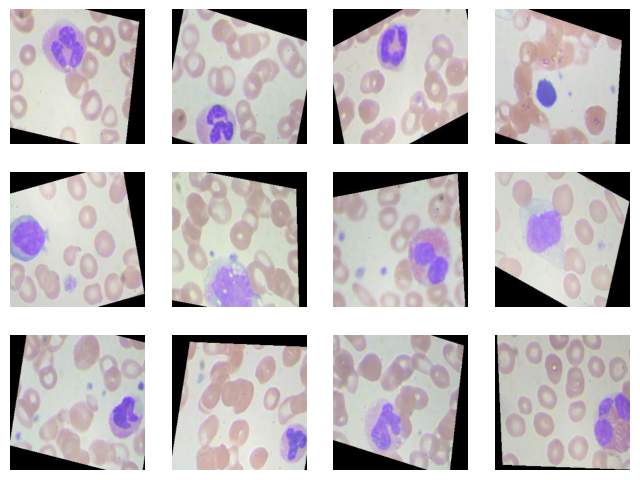

2025-02-25 16:00:16.190787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
# Parametry
IMG_SIZE = (320, 240)
TARGET_SIZE = (240, 240)
BATCH_SIZE = 32
TRAIN_DIR = "images/TRAIN"
TEST_DIR = "images/TEST"

# Wczytanie zbioru treningowego
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Wczytanie zbioru testowego
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Normalizacja wartości pikseli do [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Podgląd danych
plt.figure(figsize=(8,6))
for images, labels in train_dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


## Budowa modelu do klasyfikacji komórek krwi

Model składa się w pierwszej kolejności z warstwy przyjmującej obraz 240x240 px w formacie RGB. Dalej znajdują się trzy bloki konwolucji z filtrami, oraz zmniejszającymi rozmiary obrazu. Na końcu znajduje się warstwa spłaszczająca obraz do jednego wymiaru, gęsta warstwa i warstwa wyjściowa z czterema wyjściami.


In [45]:
model = tf.keras.Sequential([
    layers.InputLayer((240, 240, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4,4),
    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3,3),
    layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_93 (Conv2D)              │ (None, 240, 240, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 240, 240, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 20, 20, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 20, 20, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 10, 10, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,876 (460.45 KB)

 Trainable params: 117,684 (459.70 KB)

 Non-trainable params: 192 (768.00 B)

In [46]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model.save("blood_cell_classifier_small.h5")

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 86s 269ms/step - accuracy: 0.3288 - loss: 1.4061 - val_accuracy: 0.3450 - val_loss: 2.0686
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 86s 275ms/step - accuracy: 0.7779 - loss: 0.5400 - val_accuracy: 0.3876 - val_loss: 2.6805
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 90s 289ms/step - accuracy: 0.9141 - loss: 0.2282 - val_accuracy: 0.4584 - val_loss: 3.0518
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 100s 319ms/step - accuracy: 0.9462 - loss: 0.1400 - val_accuracy: 0.3534 - val_loss: 5.8015
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 340ms/step - accuracy: 0.9703 - loss: 0.0851 - val_accuracy: 0.6683 - val_loss: 1.3111
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 339ms/step - accuracy: 0.9780 - loss: 0.0651 - val_accuracy: 0.3647 - val_loss: 6.4876
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 338ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.3715 - val_loss: 22.7285
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 104s 334ms/step - accuracy: 0.9833 - l

## Budowanie mniejszego modelu

Poprzednie dopasowanie modelu trwało 16.5 minuty. Z ciekawości postanowiłem przygotować drugi, okrojony model, który zawiera tylko dwie warstwy konwolucji i filtr, który obcina połowę wyników.

In [51]:
model2 = tf.keras.Sequential([
    layers.InputLayer((240, 240, 3)),
    layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4,4),
    layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4,4),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])


model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 240, 240, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 240, 240, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 60, 60, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │       115,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,260 (461.95 KB)

 Trainable params: 118,196 (461.70 KB)

 Non-trainable params: 64 (256.00 B)

In [52]:
EPOCHS = 10

history2 = model2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model2.save("blood_cell_classifier_even_smaller.h5")


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.2531 - loss: 1.5249 - val_accuracy: 0.2533 - val_loss: 1.3860
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.2422 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.2435 - loss: 1.3864 - val_accuracy: 0.2509 - val_loss: 1.3863
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.2554 - loss: 1.3863 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 163ms/step - accuracy: 0.2448 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.2386 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.2404 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.2440 - loss: 1

Tym razem model budował się tylko 8.5 minuty

## Testowanie dokładności modelów

Warto teraz porównać oba modele. Wykorzystam w tym celu zbiór danych testowych (te dane nie były używane do trenowania modelu).

In [57]:
# Ewaluacja modeli
loss1, acc1 = model.evaluate(test_dataset, verbose=0)
print(f"Model 1 - strata: {loss1:.4f}, dokładność: {acc1:.4f}")

loss2, acc2 = model2.evaluate(test_dataset, verbose=0)
print(f"Model 2 - strata: {loss2:.4f}, dokładność: {acc2:.4f}")


Model 1 - strata: 4.2308, dokładność: 0.5850
Model 2 - strata: 1.3863, dokładność: 0.2493


## Wnioski

Model 1 (większy) osiągnął dokładność 58.5%, ale jego strata jest wysoka (4.23). Oznacza to, że model może mieć problem z dobrze dopasowanymi predykcjami, ale mimo to klasyfikuje lepiej niż losowo.

Model 2 (mniejszy) ma niższą stratę (1.39), ale jego dokładność jest niska (24.9%). Oznacza to, że model jest zbyt prosty i nie nauczył się wystarczająco dobrze.

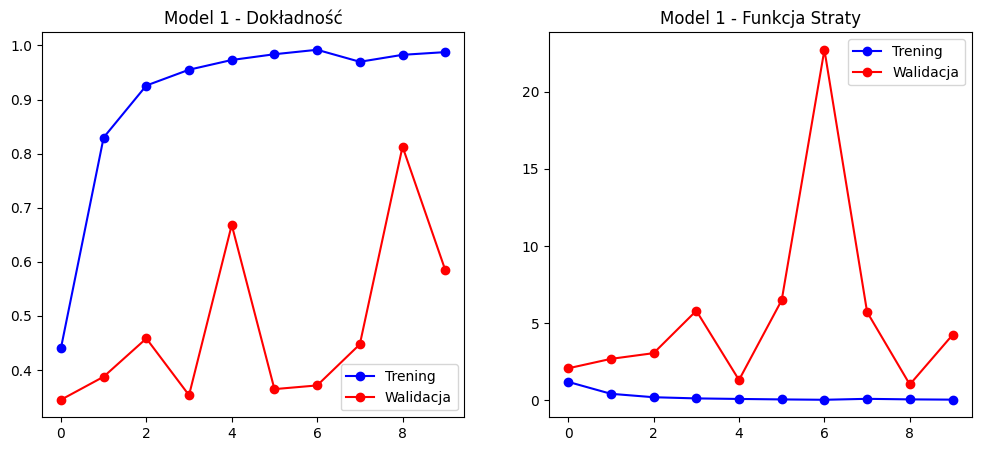

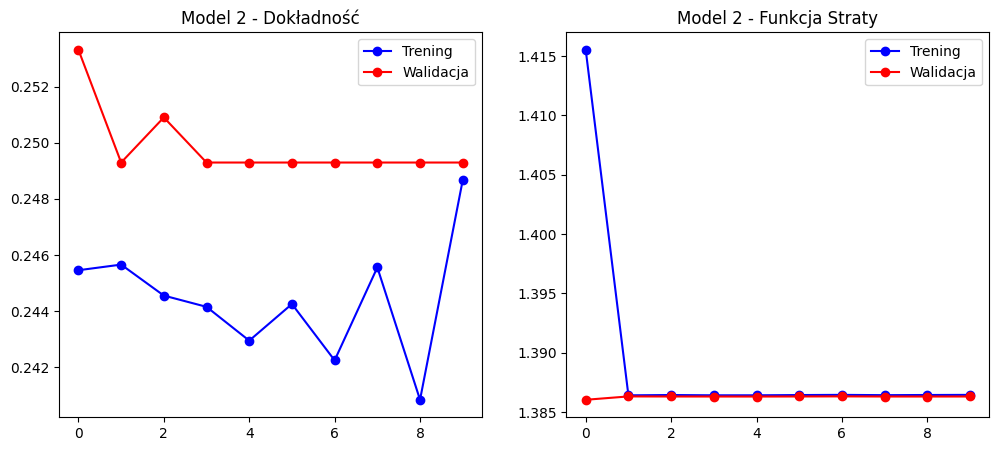

In [58]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    # Wykres dokładności
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Trening')
    plt.plot(epochs, val_acc, 'ro-', label='Walidacja')
    plt.title(f'{title} - Dokładność')
    plt.legend()

    # Wykres funkcji straty
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Trening')
    plt.plot(epochs, val_loss, 'ro-', label='Walidacja')
    plt.title(f'{title} - Funkcja Straty')
    plt.legend()

    plt.show()

# Rysowanie wykresów
plot_history(history, "Model 1")
plot_history(history2, "Model 2")

## Podsumowanie

Ostatecznie oba modele nie wykazały się zbyt wybitnymi rezultatami, zwłaszcza jeśli porównamy je z przykładowymi modelami, które można znaleźć w internecie dla tego samego zboru danych (na przykład: [Blood Cell Images using CNN model 98.5%](https://www.kaggle.com/code/mohamedgobara/blood-cell-images-using-cnn-model-98-5)). Model taki zawiera jednak o wiele więcej warstw, a jego szkolenie jest o wiele bardziej wymagające sprzętowo. Dalszym sposobem na rozwój projektu mogłoby być dodanie kolejnych warstw sieci, lub też zwiększenie zbioru danych. 